# Aim

- Apply unsupervised method on the face olivette dataset
- Apply various unsupervised techniques and see which work best for the data
- Apply pca, kmeans as a preprocessing
- Take the test data and create a label for the test data using the semi-supervised method
- Have a validation dataset to verify the create label is close to the validation test label before propagating it into the test set

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces,make_blobs 
from skimage.io import imshow
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics,preprocessing
from sklearn.cluster import KMeans,DBSCAN,MiniBatchKMeans
from sklearn.metrics import silhouette_samples,silhouette_score,classification_report,homogeneity_completeness_v_measure,accuracy_score
from sklearn.pipeline import Pipeline
from clusterval import Clusterval
import warnings
warnings.filterwarnings("ignore")

# Dataset Loading

Olivetti faces dataset which contains a set of face images taken between April 1992 and April 1994 at AT&T Laboratories Cambridge.This dataset consists of 10 pictures each of 40 individuals. 

In [2]:
faces = fetch_olivetti_faces()
#data, target = fetch_olivetti_faces(return_X_y=True) # Can also do like this

In [3]:
faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

# About Dataset

In [4]:
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [5]:
faces['data'].shape , faces['images'].shape, faces['target'].shape

((400, 4096), (400, 64, 64), (400,))

In [6]:
print("unique target number: ",np.unique(faces['target']))

unique target number:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


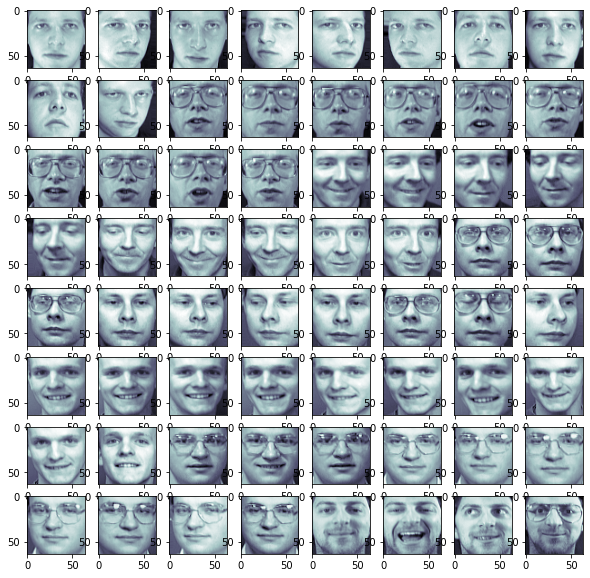

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(64):
    ax= fig.add_subplot(8,8,i+1)
    ax.imshow(faces.images[i] , cmap=plt.cm.bone)
plt.show()

In [8]:
X=faces.data
labels=faces.target

In [9]:
X.shape, labels.shape

((400, 4096), (400,))

# Train-Test Split

In [10]:
X_train, X_test, y_train, y_test=train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=0)
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)

X_train shape: (320, 4096)
y_train shape: (320,)


# Dimensionality Reduction

We will use ``Principal component analysis (PCA)``to eliminate features. 

It is a technique used to ``emphasize variation`` and ``bring out strong patterns`` in a dataset.

## Principal component analysis (PCA)

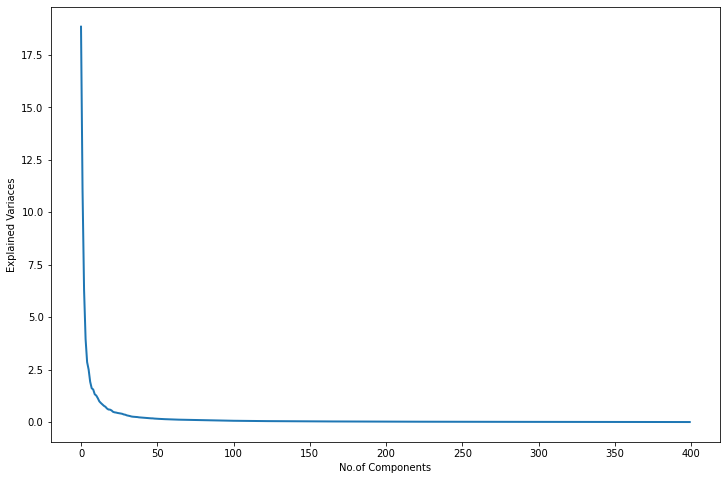

In [11]:
pca=PCA()
pca.fit(X)
plt.figure(1, figsize=(12,8))
plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('No.of Components')
plt.ylabel('Explained Variaces')
plt.show()

**We can see above the values after around 40 are the same. This means that there are 40 important components that can describe the data well.**

In [12]:
#n_components=40
pca=PCA(n_components=0.95, whiten=True)
pca.fit(X)

PCA(n_components=0.95, whiten=True)

**We will plot average face. That is we will take the mean of the faces based on the calculated PCA.**

Text(0.5, 1.0, 'Average Face')

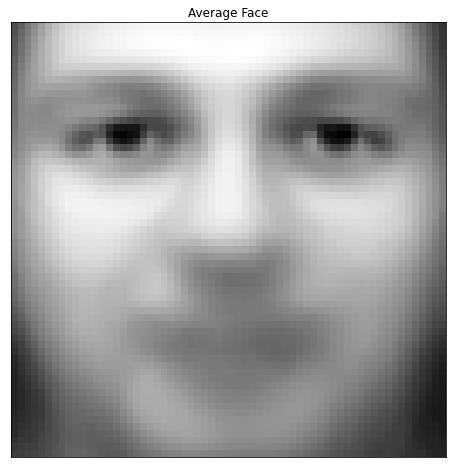

In [13]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.imshow(pca.mean_.reshape((64,64)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

**Transform the training and testing sets using PCA**

In [14]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)
print(f"Shape before {X_train.shape} vs shape after {X_train_pca.shape}")

Shape before (320, 4096) vs shape after (320, 123)


**So now we were able to decrease the dimension of the inputs.**

**LogisticRegression to study the accuracy of the model after we applied the PCA transformation.**

In [15]:
clf = LogisticRegression()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print(f"Accuracy score:{(metrics.accuracy_score(y_test, y_pred))}")

Accuracy score:0.8875


# KMeans - silhouette score

In [16]:
kmeans_per_k=[KMeans(n_clusters=k,random_state=42).fit(X) for k in range(20,60)]
inertia=[model.inertia_ for model in kmeans_per_k]

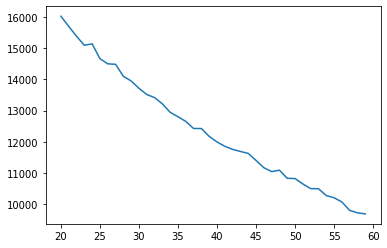

In [17]:
plt.plot(range(20,60),inertia)

In [18]:
sil_score=[silhouette_score(X,model.labels_) for model in  kmeans_per_k[:]]

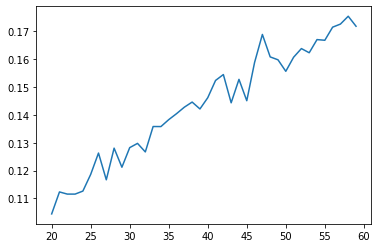

In [20]:
plt.plot(range(20,60),sil_score)

## Using Clusterval to determine the optimal number of clusters

In [21]:
c = Clusterval(min_k=20, max_k=60, algorithm='kmeans',bootstrap_samples=200, index='CVNN')
c.evaluate(X)

Clusterval( min_k=20, max_k=60, algorithm=kmeans, bootstrap_samples=200, index=['CVNN'])
final_k = 40

In [22]:
print(c.long_info)

* Minimum number of clusters to test: 20
* Maximum number of clusters to test: 60
* Number of bootstrap samples generated: 200
* Clustering algorithm used: kmeans

* Validation Indices calculated: ['CVNN']

* Among all indices: 



* According to the majority rule, the best number of clusters is 40


* 1 proposed 40 as the best number of clusters 

			***** Conclusion *****			
        CVNN
20  1.409091
21  1.445557
22  1.280881
23  1.259152
24  1.335848
25  1.382451
26  1.422100
27  1.273235
28  1.352952
29  1.281769
30  1.233089
31  1.255569
32  1.301642
33  1.396043
34  1.389518
35  1.418939
36  1.248117
37  1.255547
38  1.503285
39  1.161913
40  1.147967
41  1.372927
42  1.550772
43  1.289381
44  1.411110
45  1.387941
46  1.293437
47  1.270211
48  1.357192
49  1.657949
50  1.790352
51  1.653318
52  1.748709
53  1.651159
54  1.649454
55  1.443741
56  1.838252
57  1.628616
58  1.829363
59  1.590414
60  1.825026

* The best partition is:
[13 26 13  7  1  7 13 22 13  1 38 10 38 10 10 10

**According to the Clusterval majority rule using kmeans algorithm, the best number of clusters is 40**

In [24]:
Kmean = KMeans(n_clusters=40)
Kmean.fit(X)
y_pred=Kmean.predict(X)

In [25]:
# kmean will give you the label according to the index ( has to do with the cluster)
y_pred

array([13, 21, 13, 31, 21, 31, 13,  5, 13, 21, 16, 16, 16, 16, 37, 16, 16,
       16, 16, 16,  2, 29, 29, 14,  9, 14,  5,  5,  1,  1,  4,  4,  4, 20,
       20,  5, 20,  4,  4, 37, 22, 29,  2, 22, 22, 22, 22, 22, 22,  5, 20,
       20, 20, 23, 23, 23, 23, 23, 23, 23, 19, 19,  5, 19, 19,  5, 19, 19,
        5, 19,  8,  8,  8, 21,  8,  8, 21,  8,  5, 21,  2,  2,  2, 22, 22,
       22, 22, 22, 22,  4,  4,  1,  2,  2,  1,  1,  1,  1,  5,  8, 10, 10,
       10,  7,  7,  7,  7,  7,  7,  7,  1, 34, 34, 34, 34,  5, 34, 33,  1,
        1,  4,  4, 22, 22,  4,  4,  9,  5,  4,  4,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6, 37,  4, 37, 37,  4, 37,  4, 37,  4,  4, 18, 13, 13,
       13, 19, 18, 21,  5, 13, 13, 14, 14, 29, 29, 14, 31, 31, 14, 31, 31,
       20, 20,  5, 20, 20,  5, 20, 20, 20,  5, 26, 26, 26, 10, 10, 26, 10,
       10, 10, 26, 39, 39, 39,  4, 28,  4, 28, 28, 28, 39,  3,  3,  3,  4,
        4,  4,  9,  9,  4,  9, 35, 35, 35, 35, 35, 11, 35, 35, 35, 35, 20,
       20, 29, 22, 29, 22

In [26]:
# we can use attribute like labels_ to get the index given by the model
Kmean.labels_

array([13, 21, 13, 31, 21, 31, 13,  5, 13, 21, 16, 16, 16, 16, 37, 16, 16,
       16, 16, 16,  2, 29, 29, 14,  9, 14,  5,  5,  1,  1,  4,  4,  4, 20,
       20,  5, 20,  4,  4, 37, 22, 29,  2, 22, 22, 22, 22, 22, 22,  5, 20,
       20, 20, 23, 23, 23, 23, 23, 23, 23, 19, 19,  5, 19, 19,  5, 19, 19,
        5, 19,  8,  8,  8, 21,  8,  8, 21,  8,  5, 21,  2,  2,  2, 22, 22,
       22, 22, 22, 22,  4,  4,  1,  2,  2,  1,  1,  1,  1,  5,  8, 10, 10,
       10,  7,  7,  7,  7,  7,  7,  7,  1, 34, 34, 34, 34,  5, 34, 33,  1,
        1,  4,  4, 22, 22,  4,  4,  9,  5,  4,  4,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6, 37,  4, 37, 37,  4, 37,  4, 37,  4,  4, 18, 13, 13,
       13, 19, 18, 21,  5, 13, 13, 14, 14, 29, 29, 14, 31, 31, 14, 31, 31,
       20, 20,  5, 20, 20,  5, 20, 20, 20,  5, 26, 26, 26, 10, 10, 26, 10,
       10, 10, 26, 39, 39, 39,  4, 28,  4, 28, 28, 28, 39,  3,  3,  3,  4,
        4,  4,  9,  9,  4,  9, 35, 35, 35, 35, 35, 11, 35, 35, 35, 35, 20,
       20, 29, 22, 29, 22

In [27]:
np.allclose(y_pred,Kmean.labels_)

True

**Both y_pred and labels are same**

## Images in each cluster

In [28]:
centers=np.array(Kmean.cluster_centers_)

In [29]:
labels = Kmean.labels_

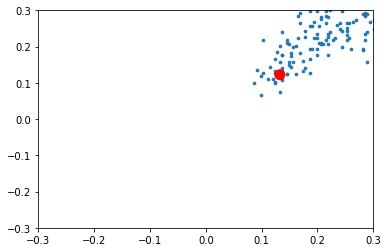

In [31]:
centers=np.array(Kmean.cluster_centers_[:5])
plt.xlim(-0.3,0.3)
plt.ylim(-0.3,0.3)
plt.scatter(X[:,0],X[:,1],s=7,cmap='viridis')
plt.scatter(centers[:,0],centers[:,1],s=100,color=['r','k','b','y','m'])
plt.show()

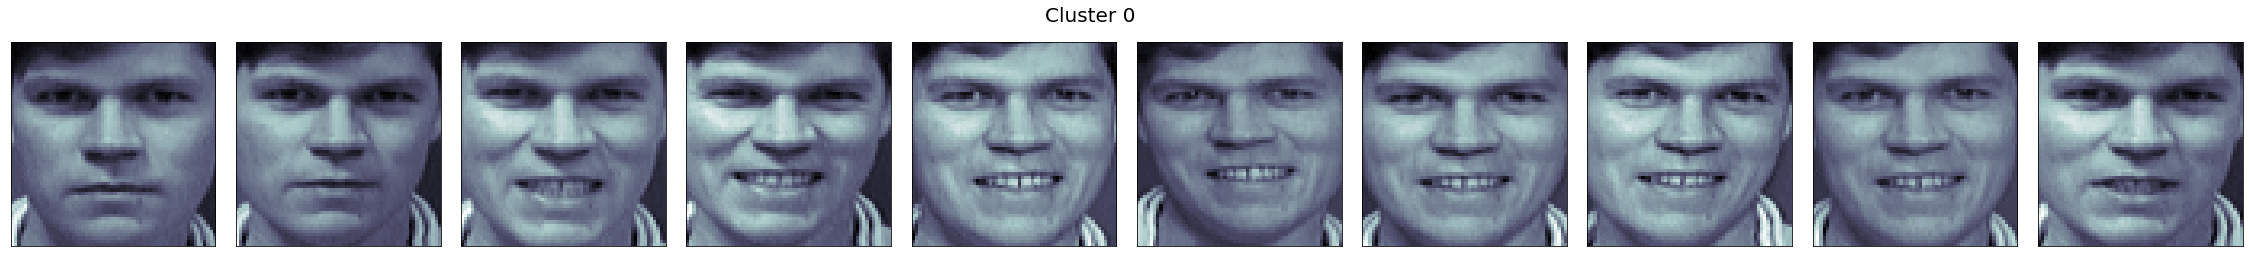

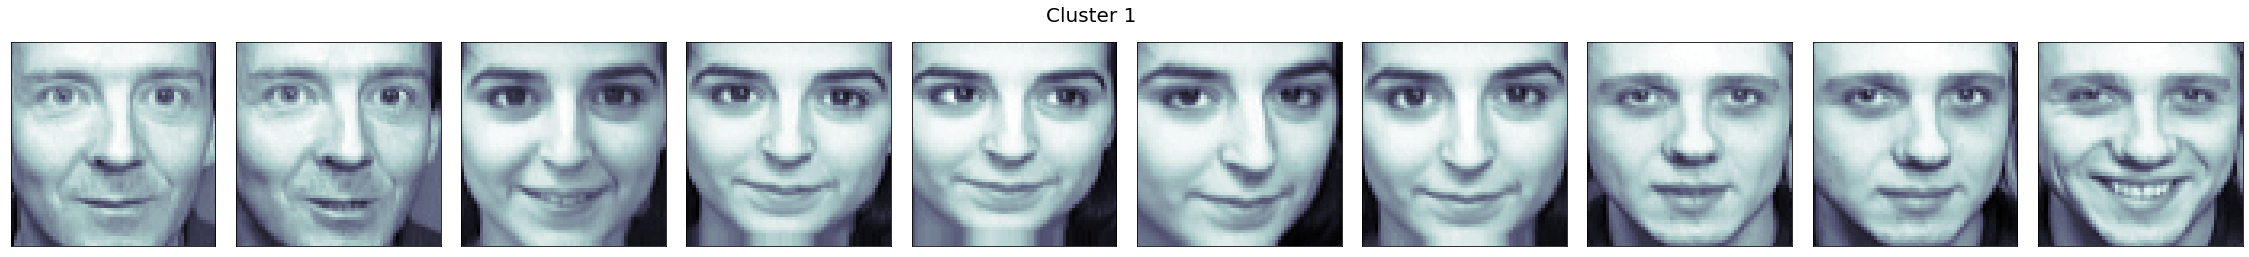

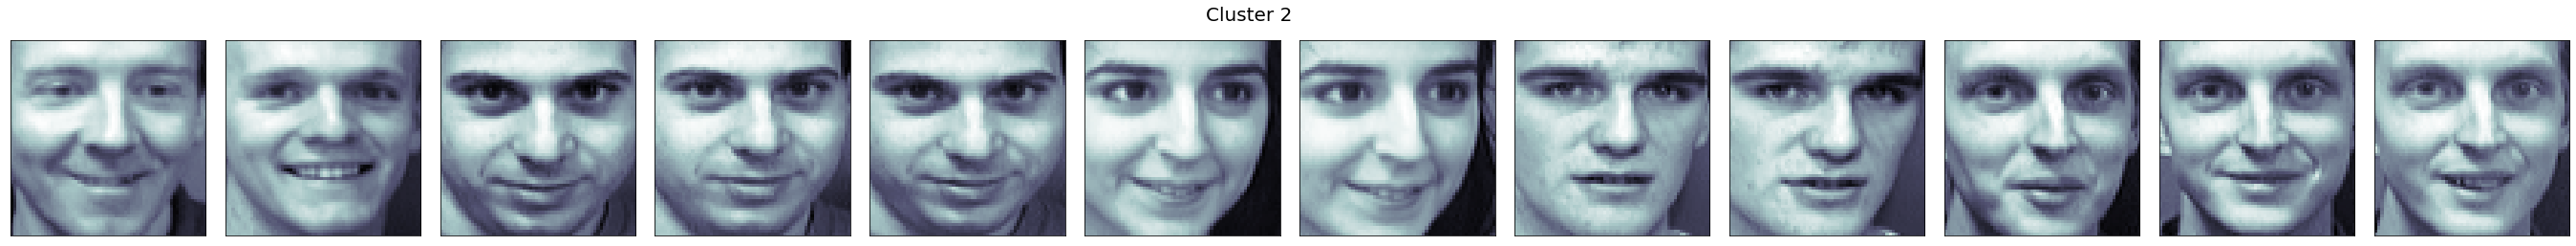

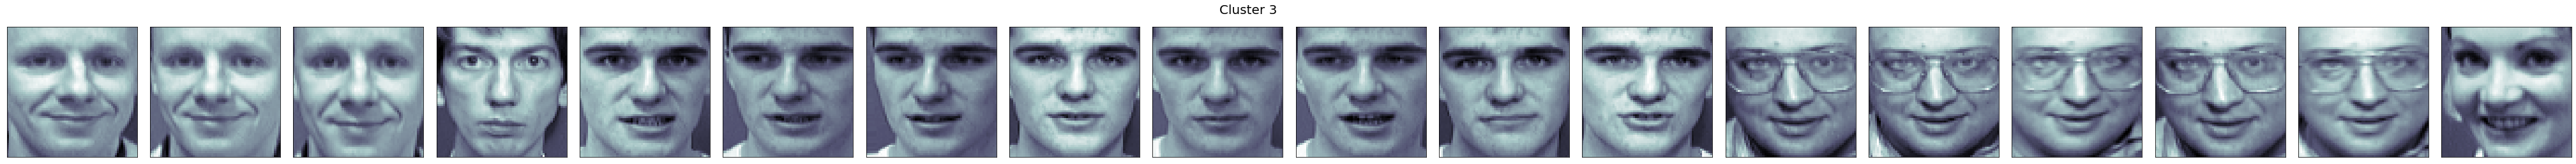

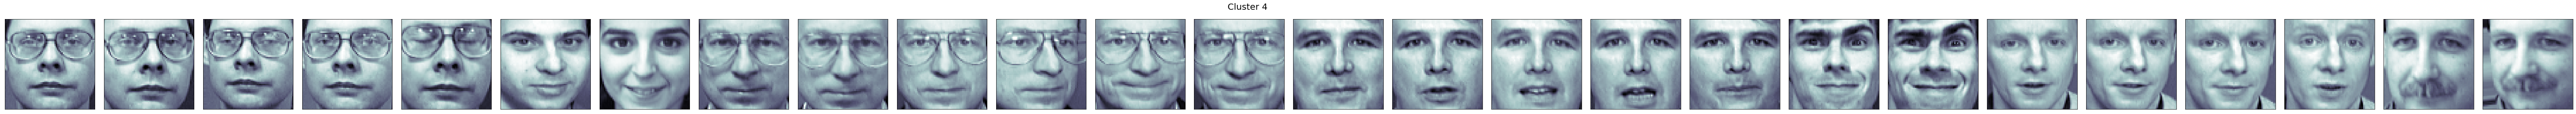

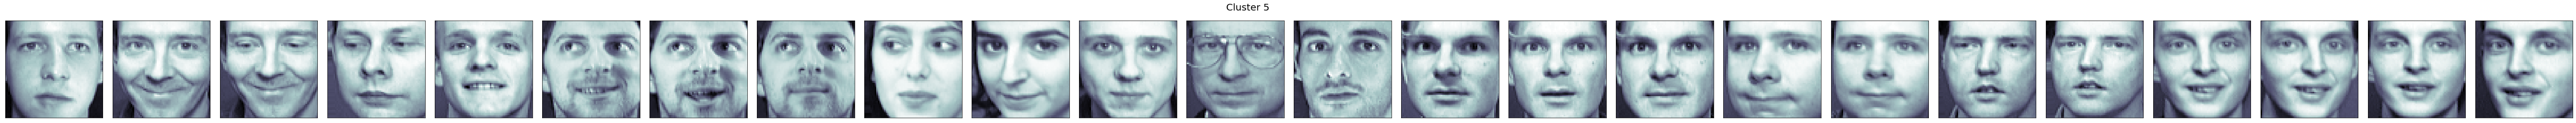

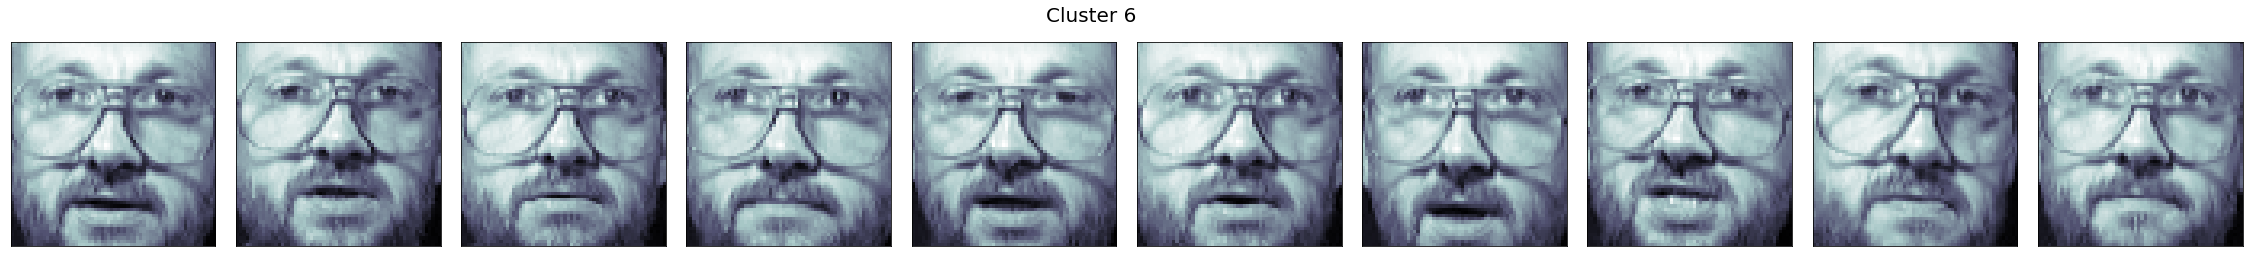

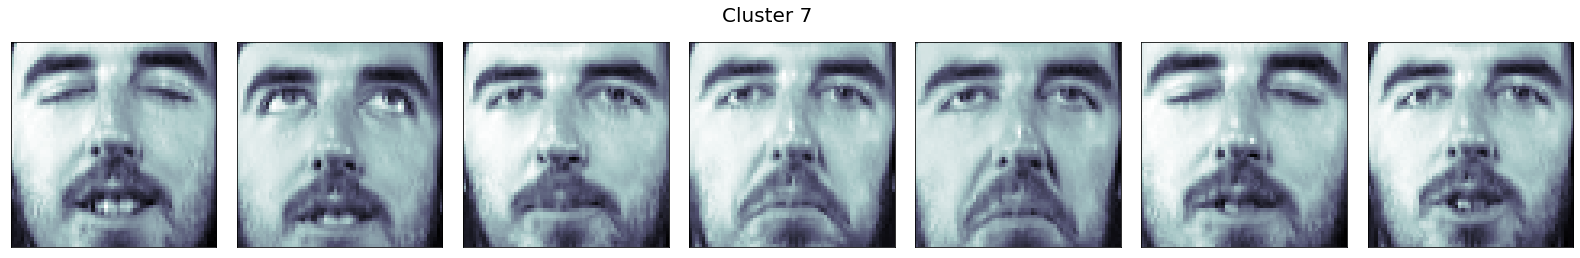

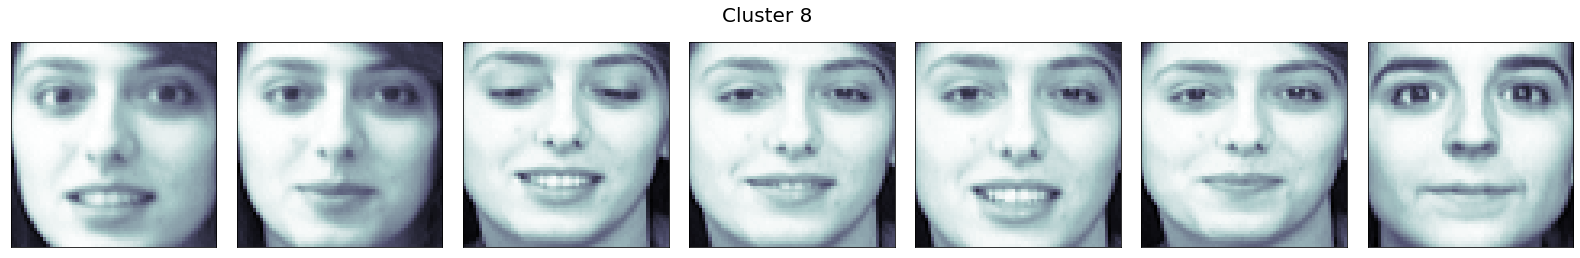

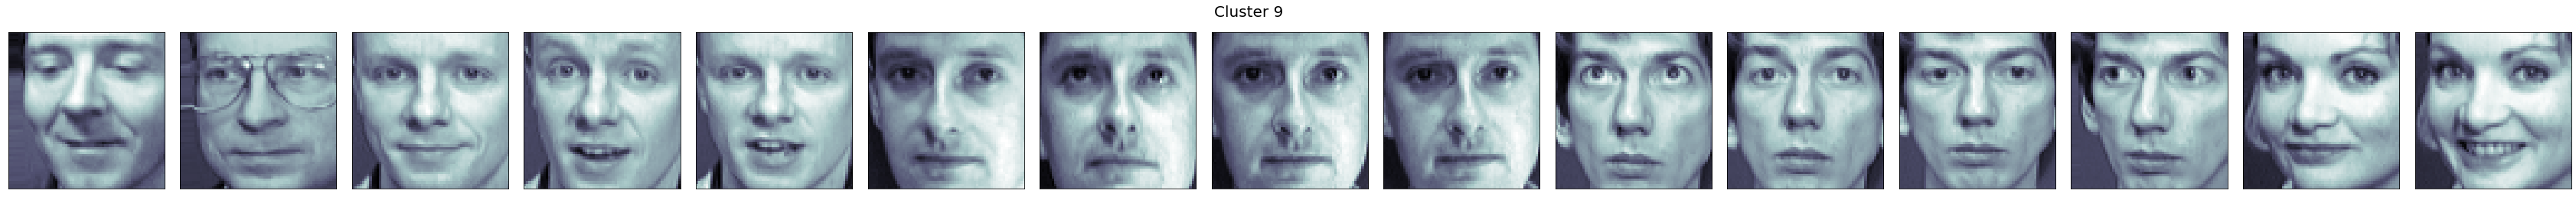

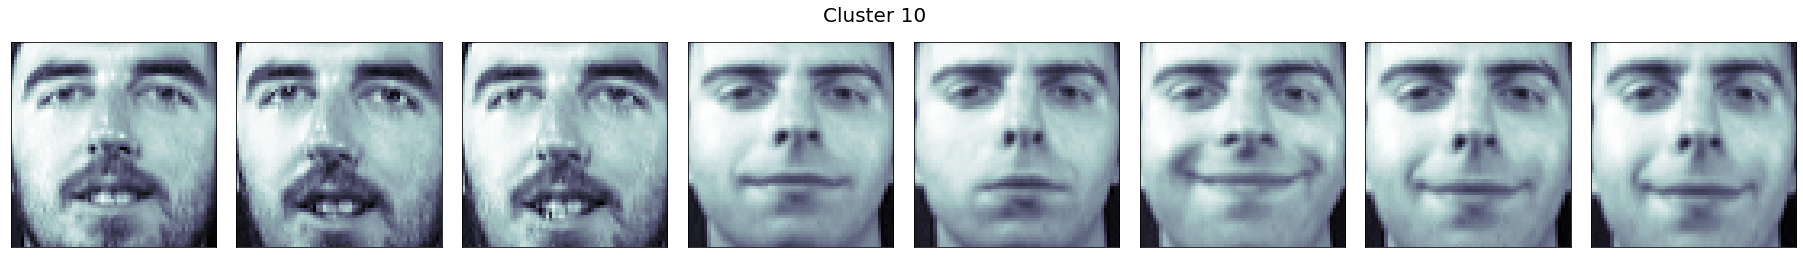

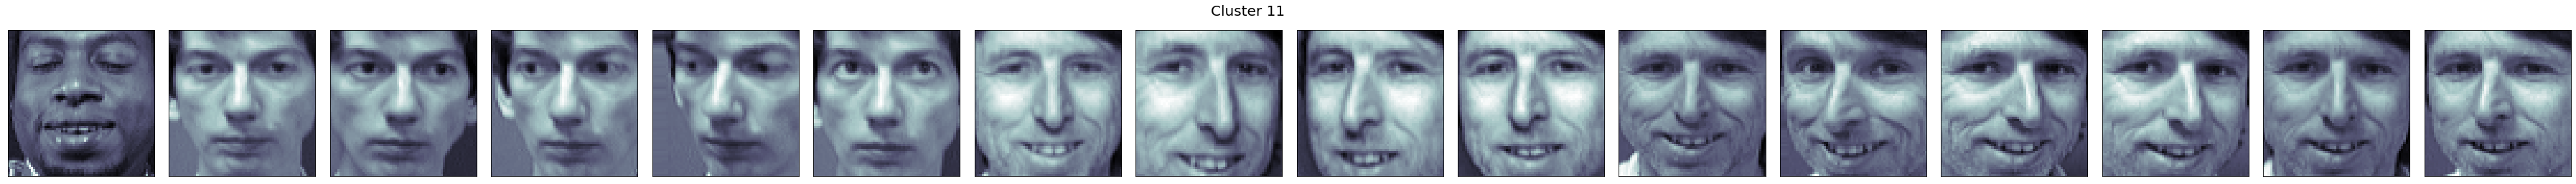

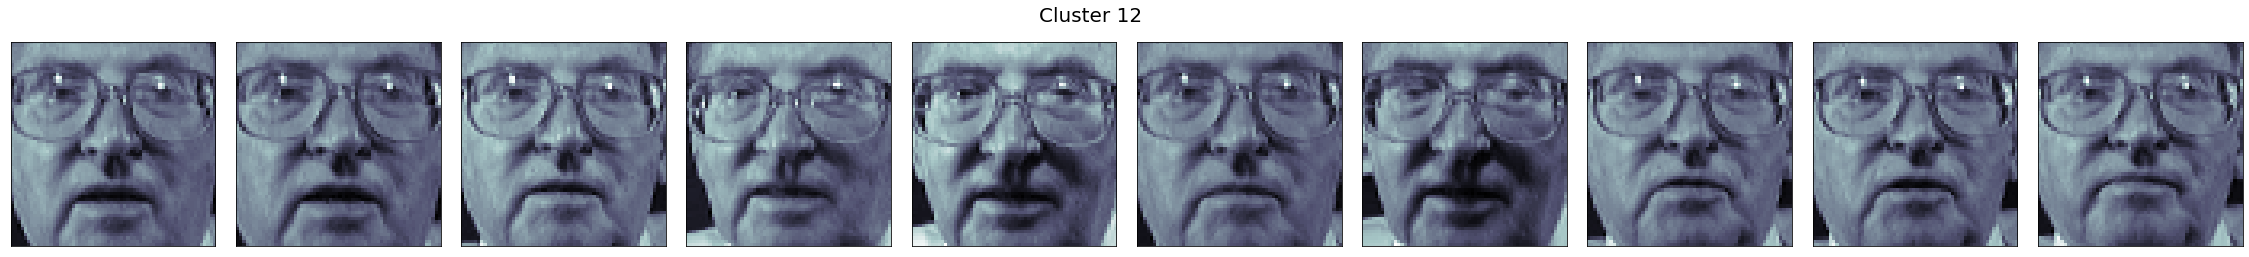

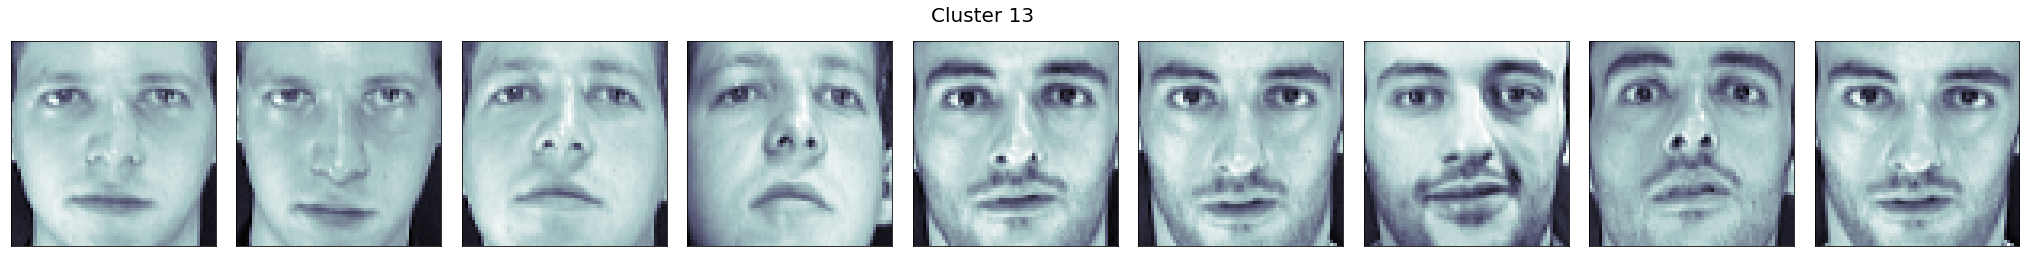

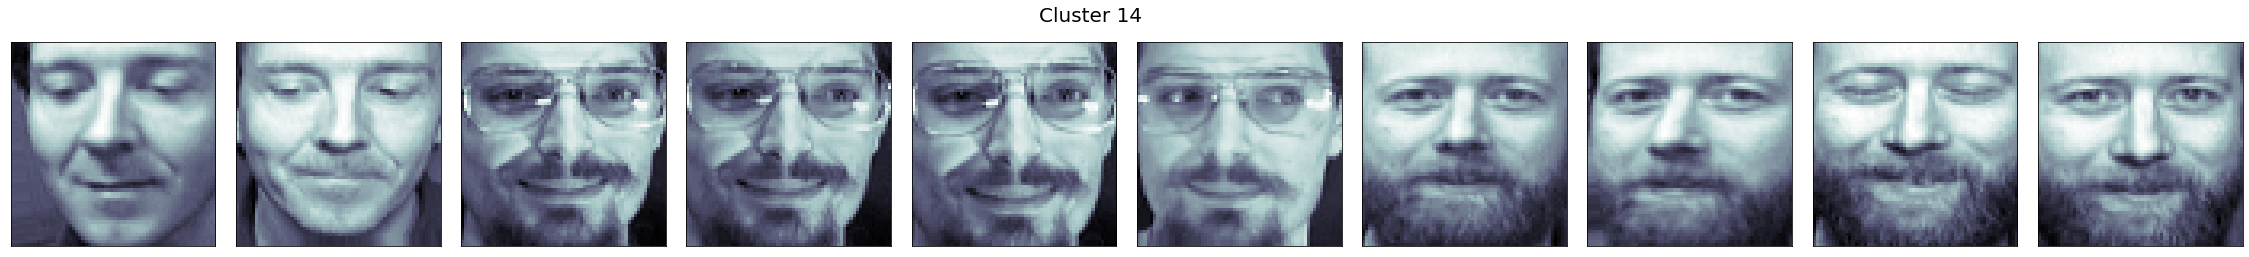

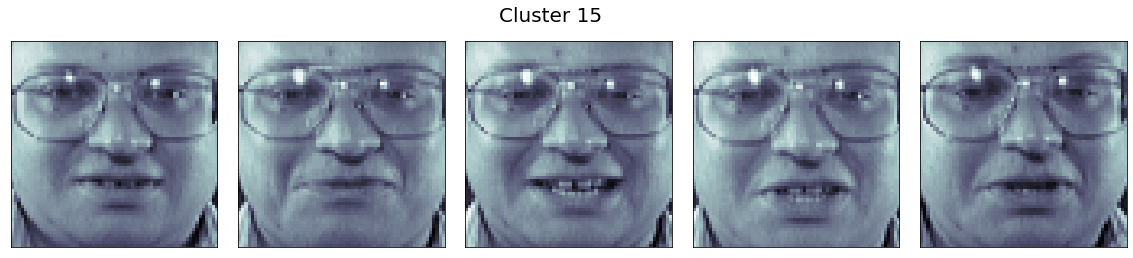

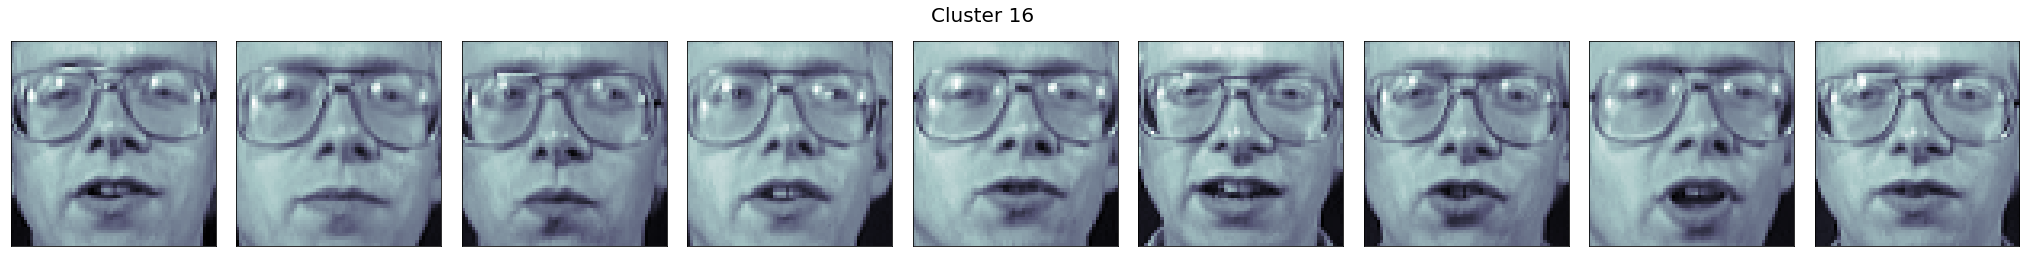

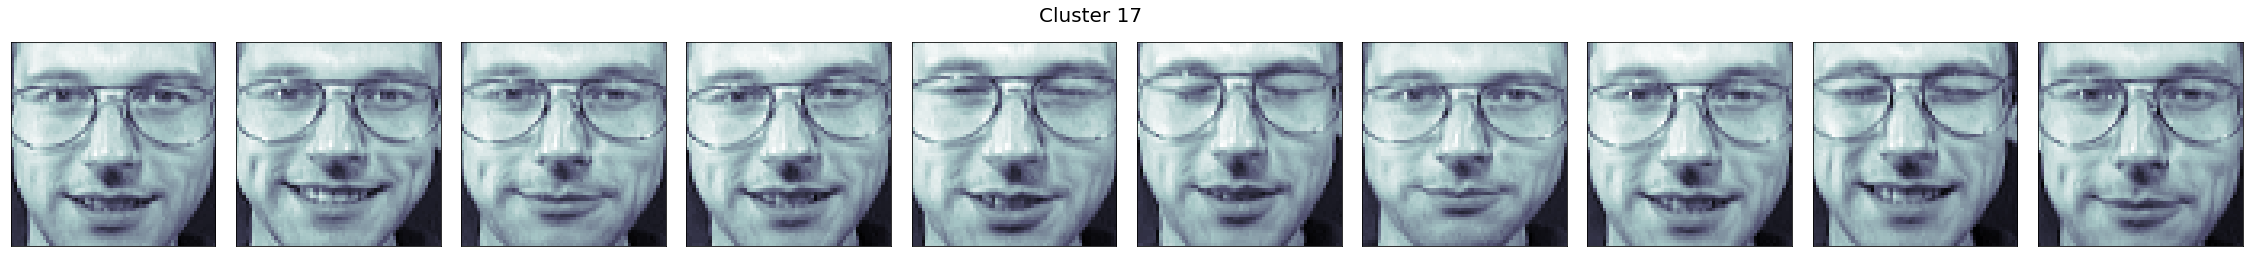

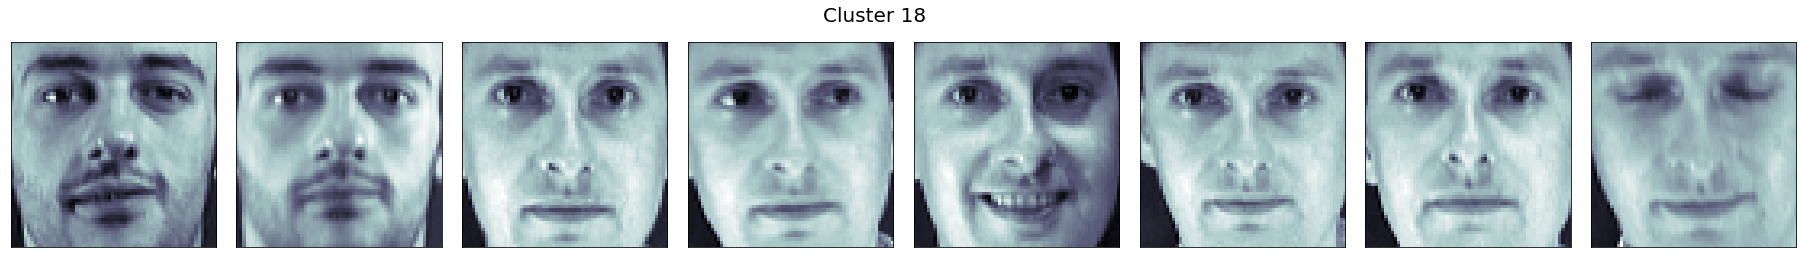

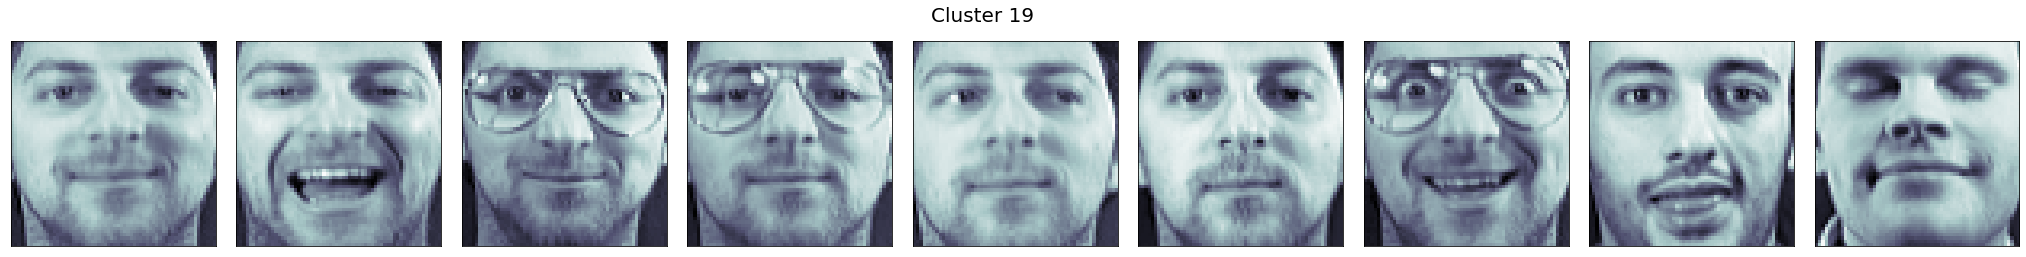

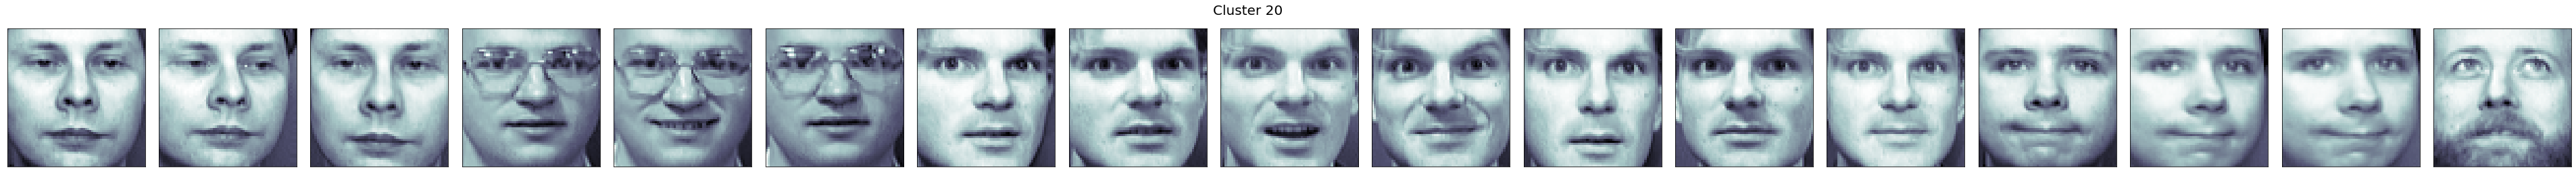

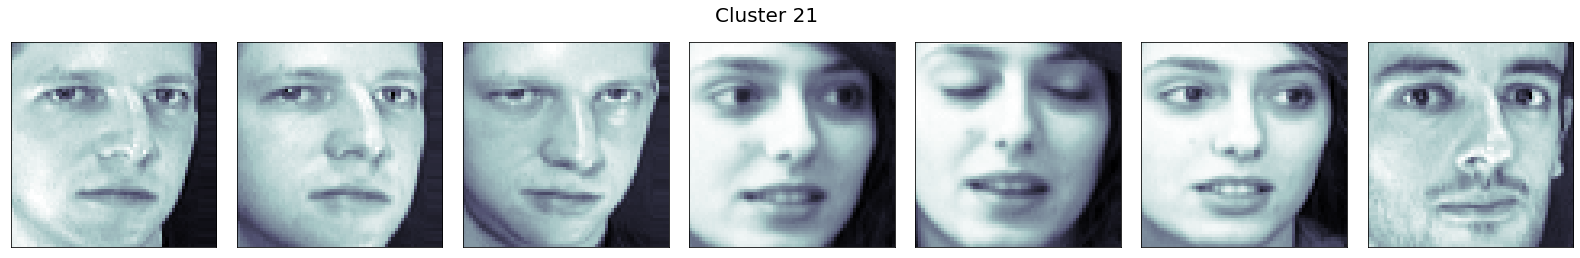

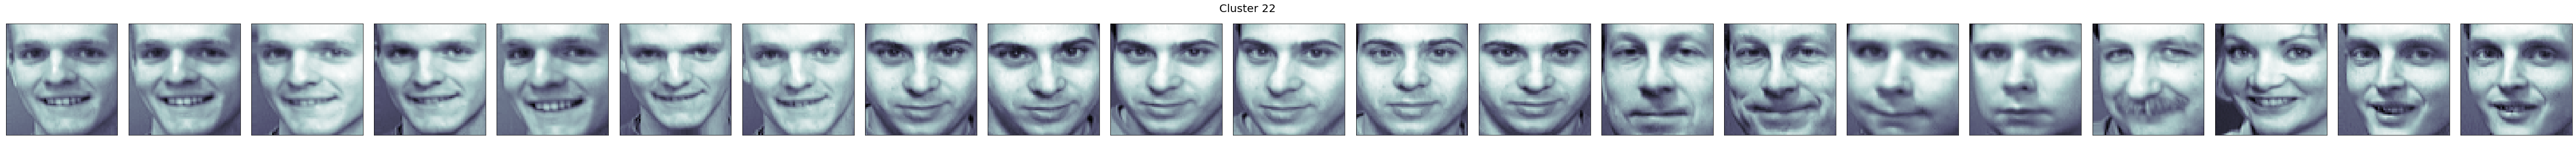

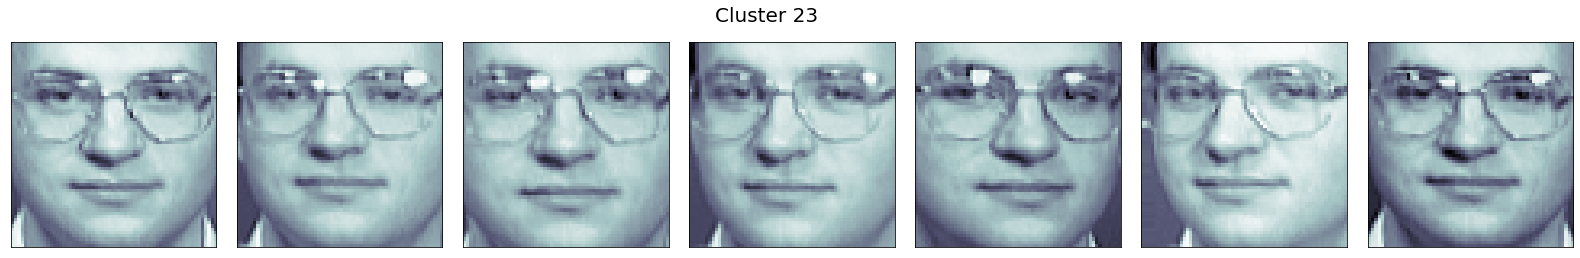

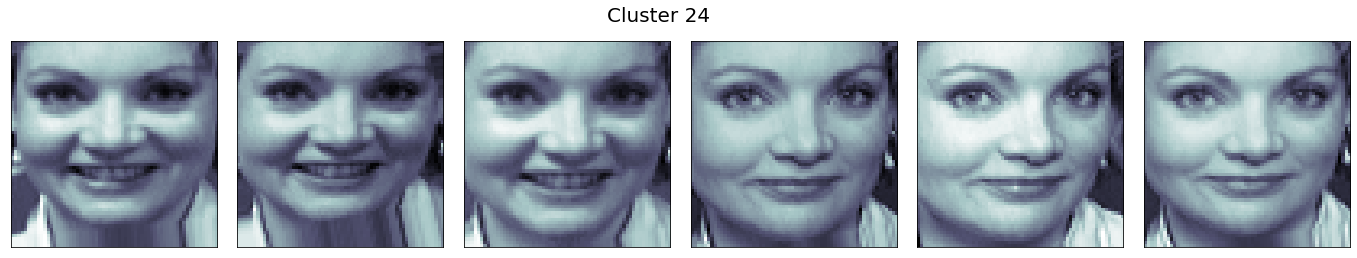

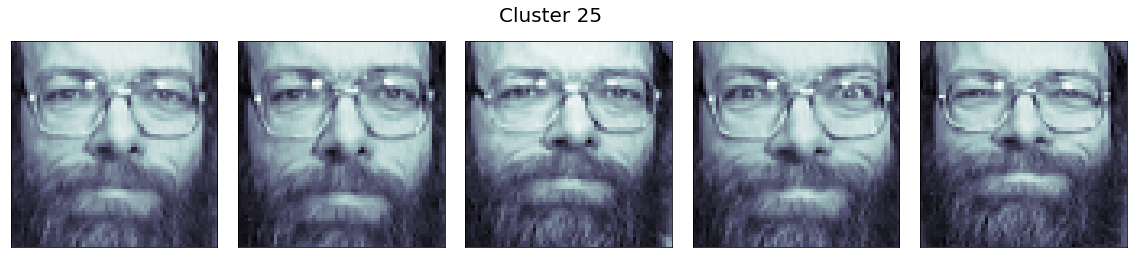

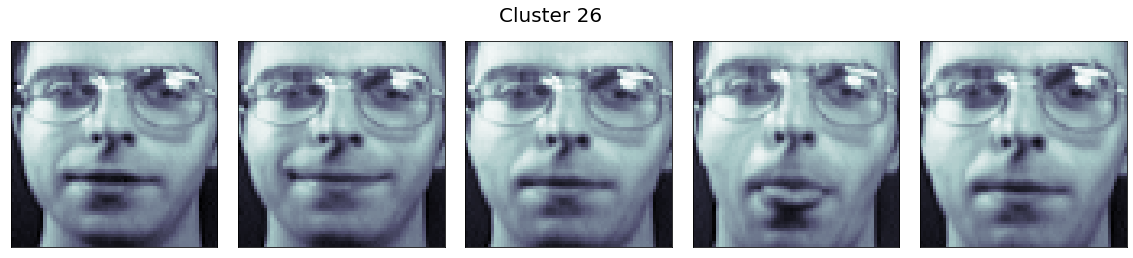

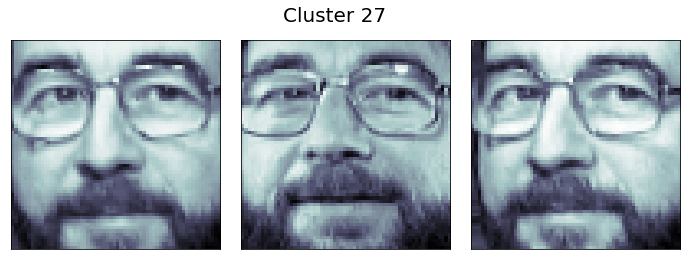

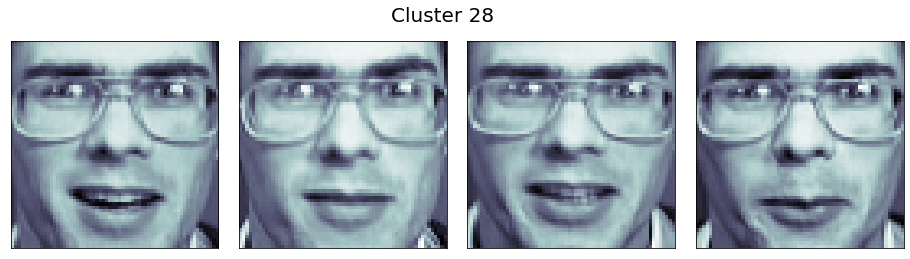

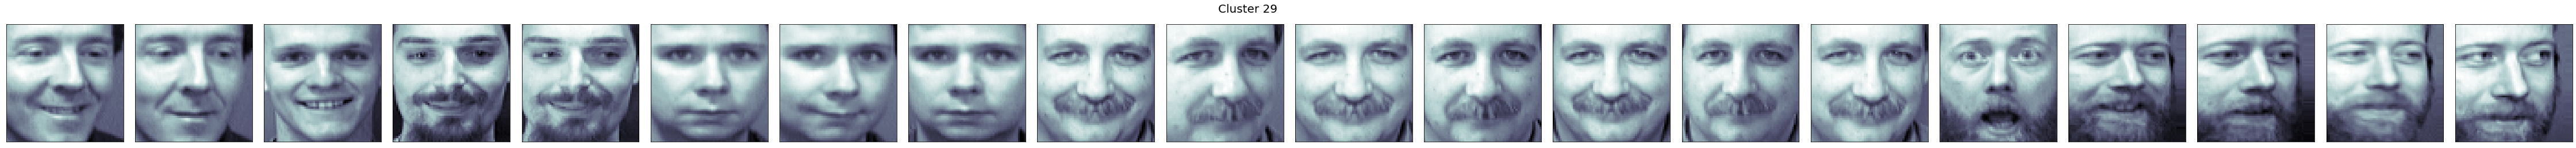

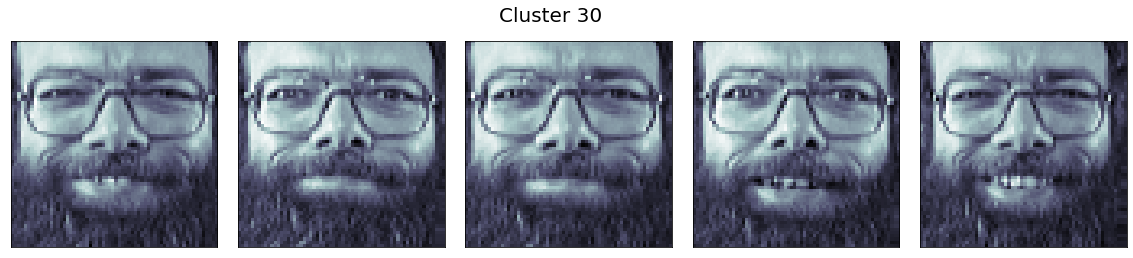

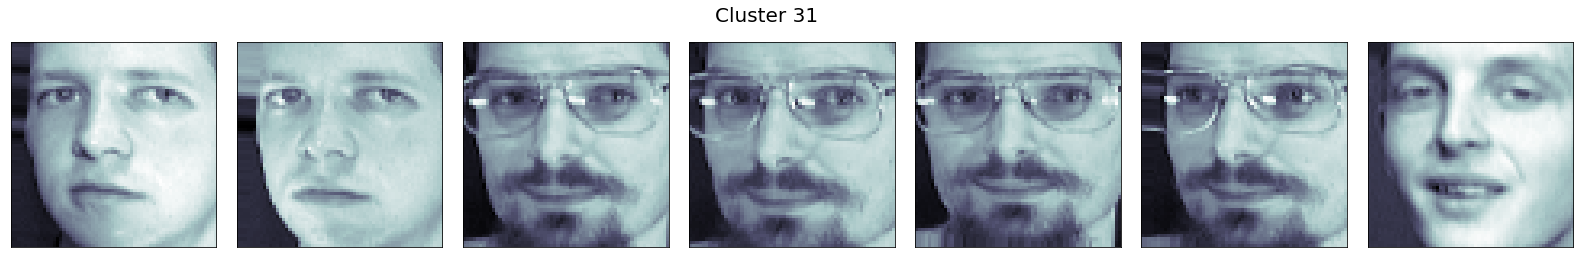

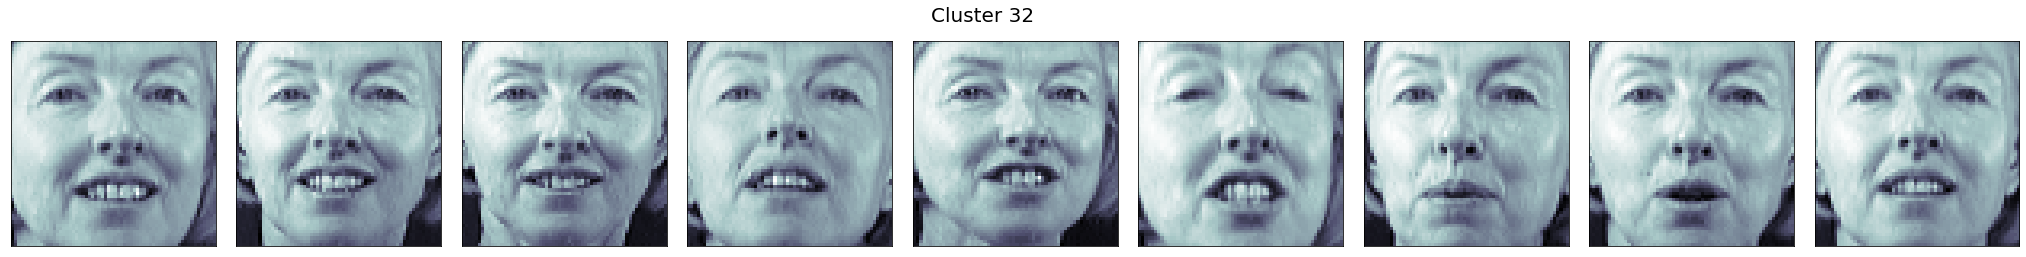

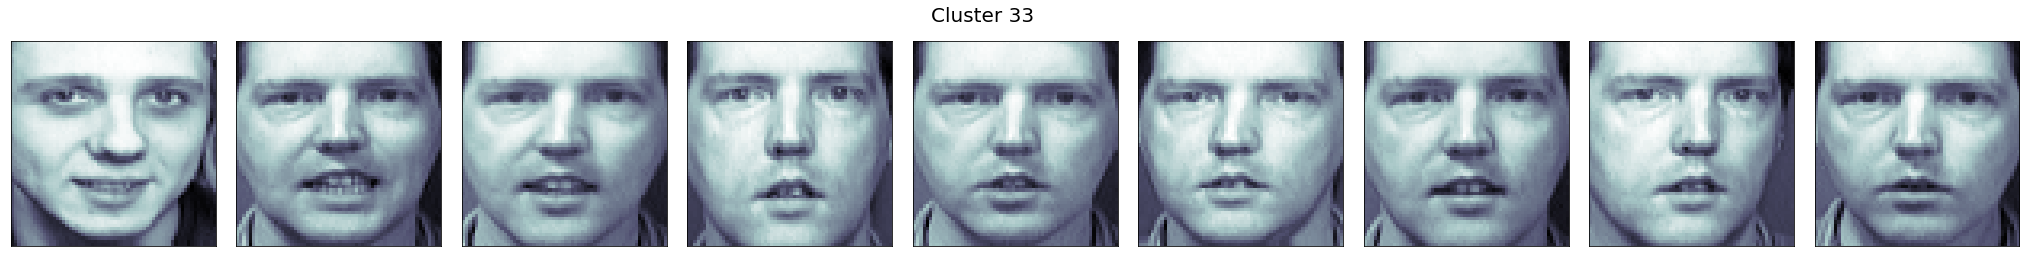

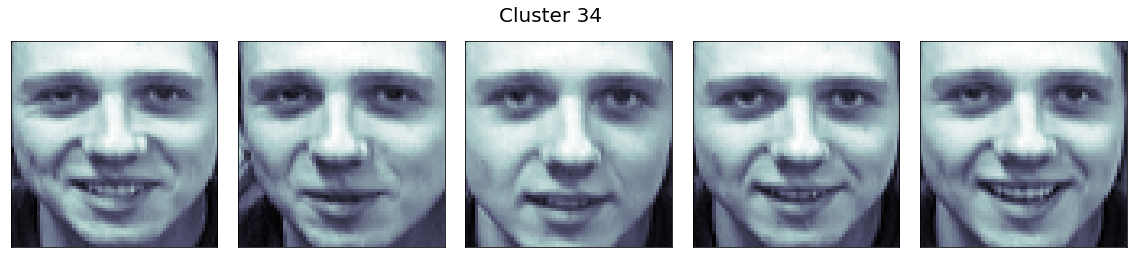

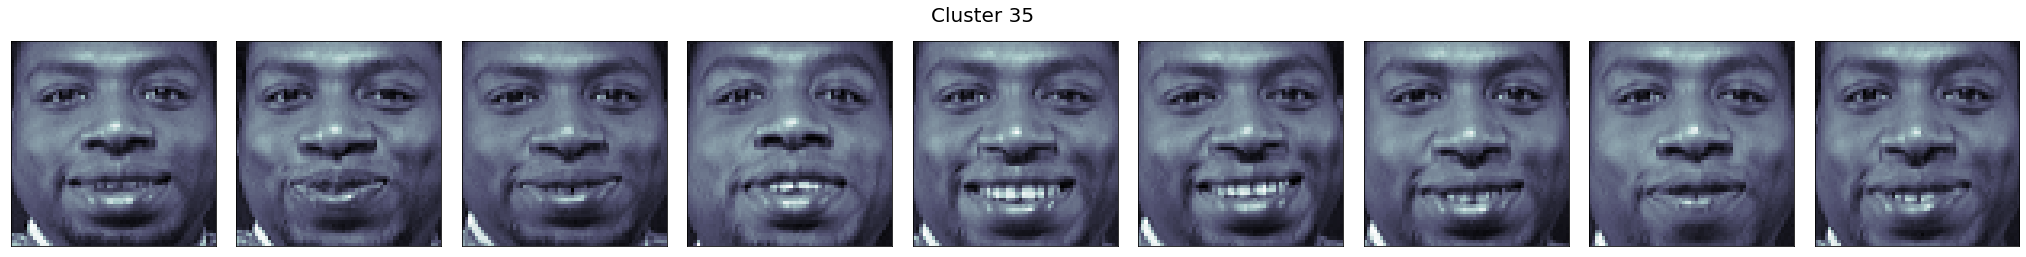

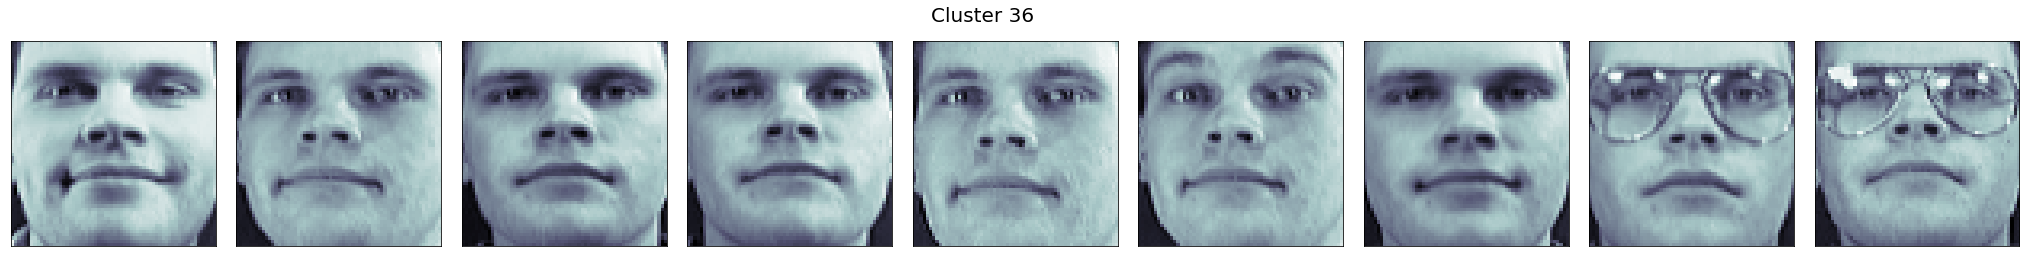

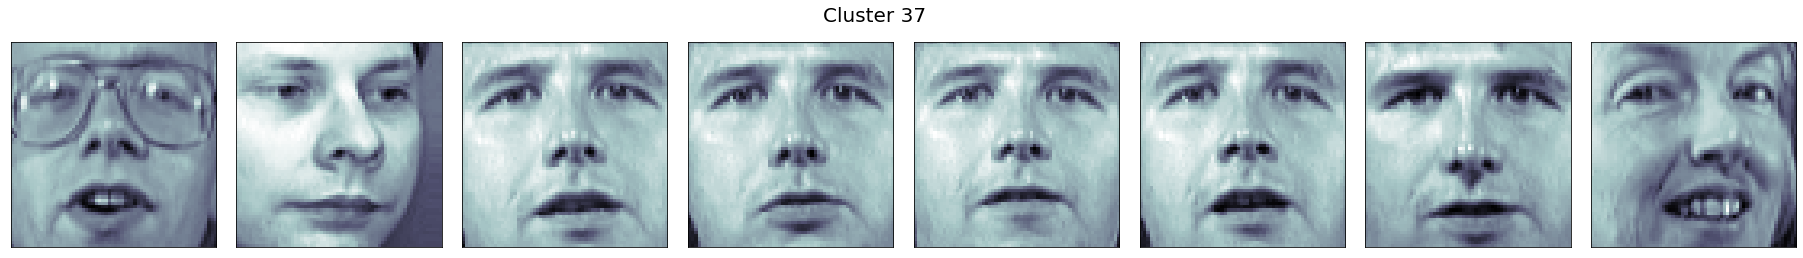

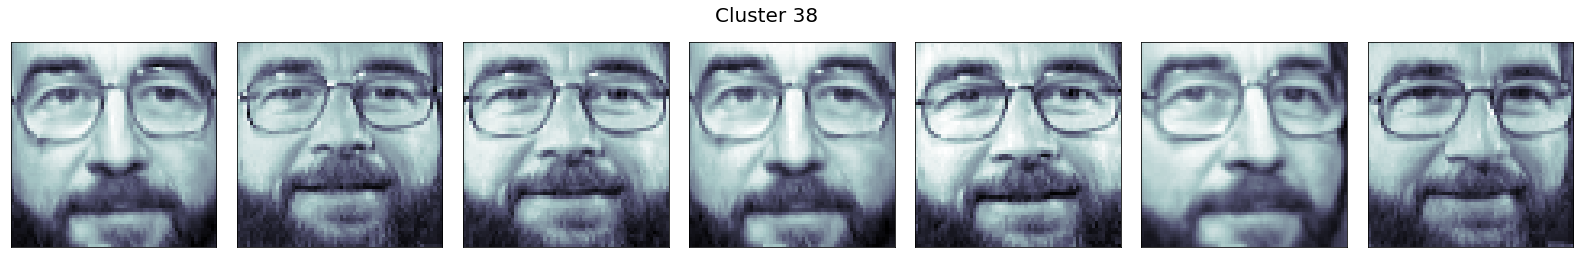

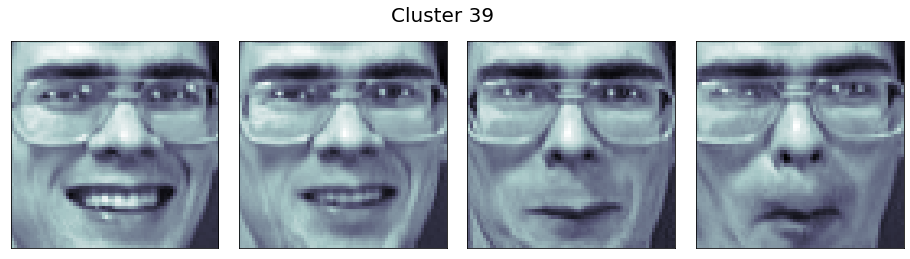

In [32]:
labels = Kmean.labels_
cluster_num = 40
for i in range(cluster_num):
    index = np.nonzero(labels==i)[0]
    num = len(index)
    this_faces = faces.images[index]
    fig, axes = plt.subplots(1, num, figsize=(4 * num, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    fig.suptitle("Cluster " + str(i), fontsize=20)
    for i, ax in enumerate(axes.flat):
        ax.imshow(this_faces[i], cmap='bone')

# Clustering for the Preprocessing

## logreg

In [33]:
log_reg=LogisticRegression(multi_class="ovr",random_state=42,max_iter=2000,C=0.1)
log_reg.fit(X_train,y_train)

LogisticRegression(C=0.1, max_iter=2000, multi_class='ovr', random_state=42)

In [34]:
print(f"training score {log_reg.score(X_train,y_train)}")
print(f"test score {log_reg.score(X_test,y_test)}")

training score 1.0
test score 0.95


## apply clustering for the preprocessing

In [37]:
score=[]
for i in range(20,60):
    model=KMeans(n_clusters=i)
    model.fit(X_train)
    score.append(model.inertia_)

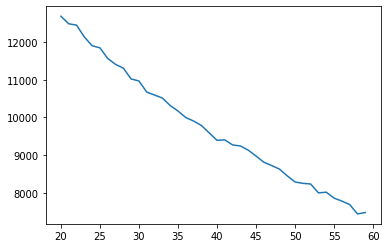

In [38]:
plt.plot(range(20,60),score)

In [39]:
sil_score=[]
for i in range(20,60):
    model=KMeans(n_clusters=i)
    model.fit(X_train)
    sil_score.append(silhouette_score(X_train,model.labels_))

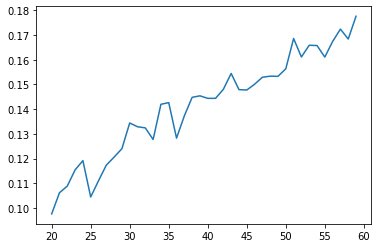

In [40]:
plt.plot(range(20,60),sil_score)

## with k=40

In [41]:
pipe=Pipeline([
    ("Kmean",KMeans(n_clusters=40,random_state=42)),
    ("logreg",LogisticRegression(max_iter=2000,random_state=42,multi_class="ovr"))
])
pipe.fit(X_train,y_train)

Pipeline(steps=[('Kmean', KMeans(n_clusters=40, random_state=42)),
                ('logreg',
                 LogisticRegression(max_iter=2000, multi_class='ovr',
                                    random_state=42))])

In [42]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

1.0
0.9375


## with k=55

In [135]:
pipe=Pipeline([
    ("Kmean",KMeans(n_clusters=55,random_state=42)),
    ("logreg",LogisticRegression(max_iter=2000,random_state=42,multi_class="ovr"))
])
pipe.fit(X_train,y_train)

Pipeline(steps=[('Kmean', KMeans(n_clusters=55, random_state=42)),
                ('logreg',
                 LogisticRegression(max_iter=2000, multi_class='ovr',
                                    random_state=42))])

In [136]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

1.0
0.95


## with k=60

In [45]:
pipe=Pipeline([
    ("Kmean",KMeans(n_clusters=60,random_state=42)),
    ("logreg",LogisticRegression(max_iter=2000,random_state=42,multi_class="ovr"))
])
pipe.fit(X_train,y_train)

Pipeline(steps=[('Kmean', KMeans(n_clusters=60, random_state=42)),
                ('logreg',
                 LogisticRegression(max_iter=2000, multi_class='ovr',
                                    random_state=42))])

In [46]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

1.0
0.9375


## GridSearchCV

In [47]:
from sklearn.model_selection import GridSearchCV
param={"Kmean__n_clusters":range(20,60)}
      #"logreg__C":[0.001,0.01,10]}
grid=GridSearchCV(pipe,param_grid=param,cv=3,n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Kmean',
                                        KMeans(n_clusters=60, random_state=42)),
                                       ('logreg',
                                        LogisticRegression(max_iter=2000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             n_jobs=-1, param_grid={'Kmean__n_clusters': range(20, 60)})

In [48]:
grid.best_estimator_

Pipeline(steps=[('Kmean', KMeans(n_clusters=52, random_state=42)),
                ('logreg',
                 LogisticRegression(max_iter=2000, multi_class='ovr',
                                    random_state=42))])

In [49]:
grid.best_score_

0.9001058014459531

In [50]:
grid.score(X_train,y_train)

1.0

In [51]:
grid.score(X_test,y_test)

0.9375

In [52]:
grid.best_params_

{'Kmean__n_clusters': 52}

**According to GridSearchCV, 52 is the best number of clusters**

## apply PCA+KMeans+logreg

In [94]:
pipe=Pipeline([
    ("pca",PCA(n_components=0.95)),
    ("Kmean",KMeans(n_clusters=55,random_state=42)),
    ("logreg",LogisticRegression(max_iter=2000,random_state=42,multi_class="ovr",C=0.1))
])
pipe.fit(X_train,y_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('Kmean', KMeans(n_clusters=55, random_state=42)),
                ('logreg',
                 LogisticRegression(C=0.1, max_iter=2000, multi_class='ovr',
                                    random_state=42))])

In [95]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

0.94375
0.925


# Semi-supervised Learning

**lets consider only we have 100 of the training label for supervised task**

In [55]:
labeled_data=100

In [56]:
np.unique(y_train[:labeled_data],return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 37, 38, 39]),
 array([2, 3, 5, 1, 3, 3, 4, 1, 2, 3, 3, 2, 1, 1, 1, 2, 1, 2, 4, 4, 3, 2,
        3, 2, 2, 4, 5, 2, 3, 4, 2, 4, 2, 3, 3, 2, 2, 2, 2]))

In [57]:
log_reg=LogisticRegression(random_state=42,multi_class="ovr",max_iter=2000,C=0.1)
log_reg.fit(X_train[:labeled_data],y_train[:labeled_data])

LogisticRegression(C=0.1, max_iter=2000, multi_class='ovr', random_state=42)

In [58]:
print(log_reg.score(X_train,y_train))
print(log_reg.score(X_test,y_test))

0.775
0.725


In [59]:
print(classification_report(y_test,log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         2
           2       0.25      1.00      0.40         2
           3       0.00      0.00      0.00         2
           4       0.40      1.00      0.57         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      0.50      0.67         2
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         2
          10       0.67      1.00      0.80         2
          11       1.00      0.50      0.67         2
          12       0.00      0.00      0.00         2
          13       1.00      0.50      0.67         2
          14       0.00      0.00      0.00         2
          15       1.00      1.00      1.00         2
          16       1.00      0.50      0.67         2
          17       0.67    

## Steps to follow

First we need to cluster the training set.

Then we find the image closest to the centroid (Also known as **``representative image``**)

In [103]:
K=55
kmeans=KMeans(n_clusters=K,random_state=42)
X_transformed=kmeans.fit_transform(X_train)
print(X_transformed.shape)

(320, 55)


In [104]:
len(np.argmin(X_transformed,axis=0))

55

### getting the representative idx and data

In [105]:
representative_idx=np.argmin(X_transformed,axis=0)
X_faces=X_train[representative_idx]

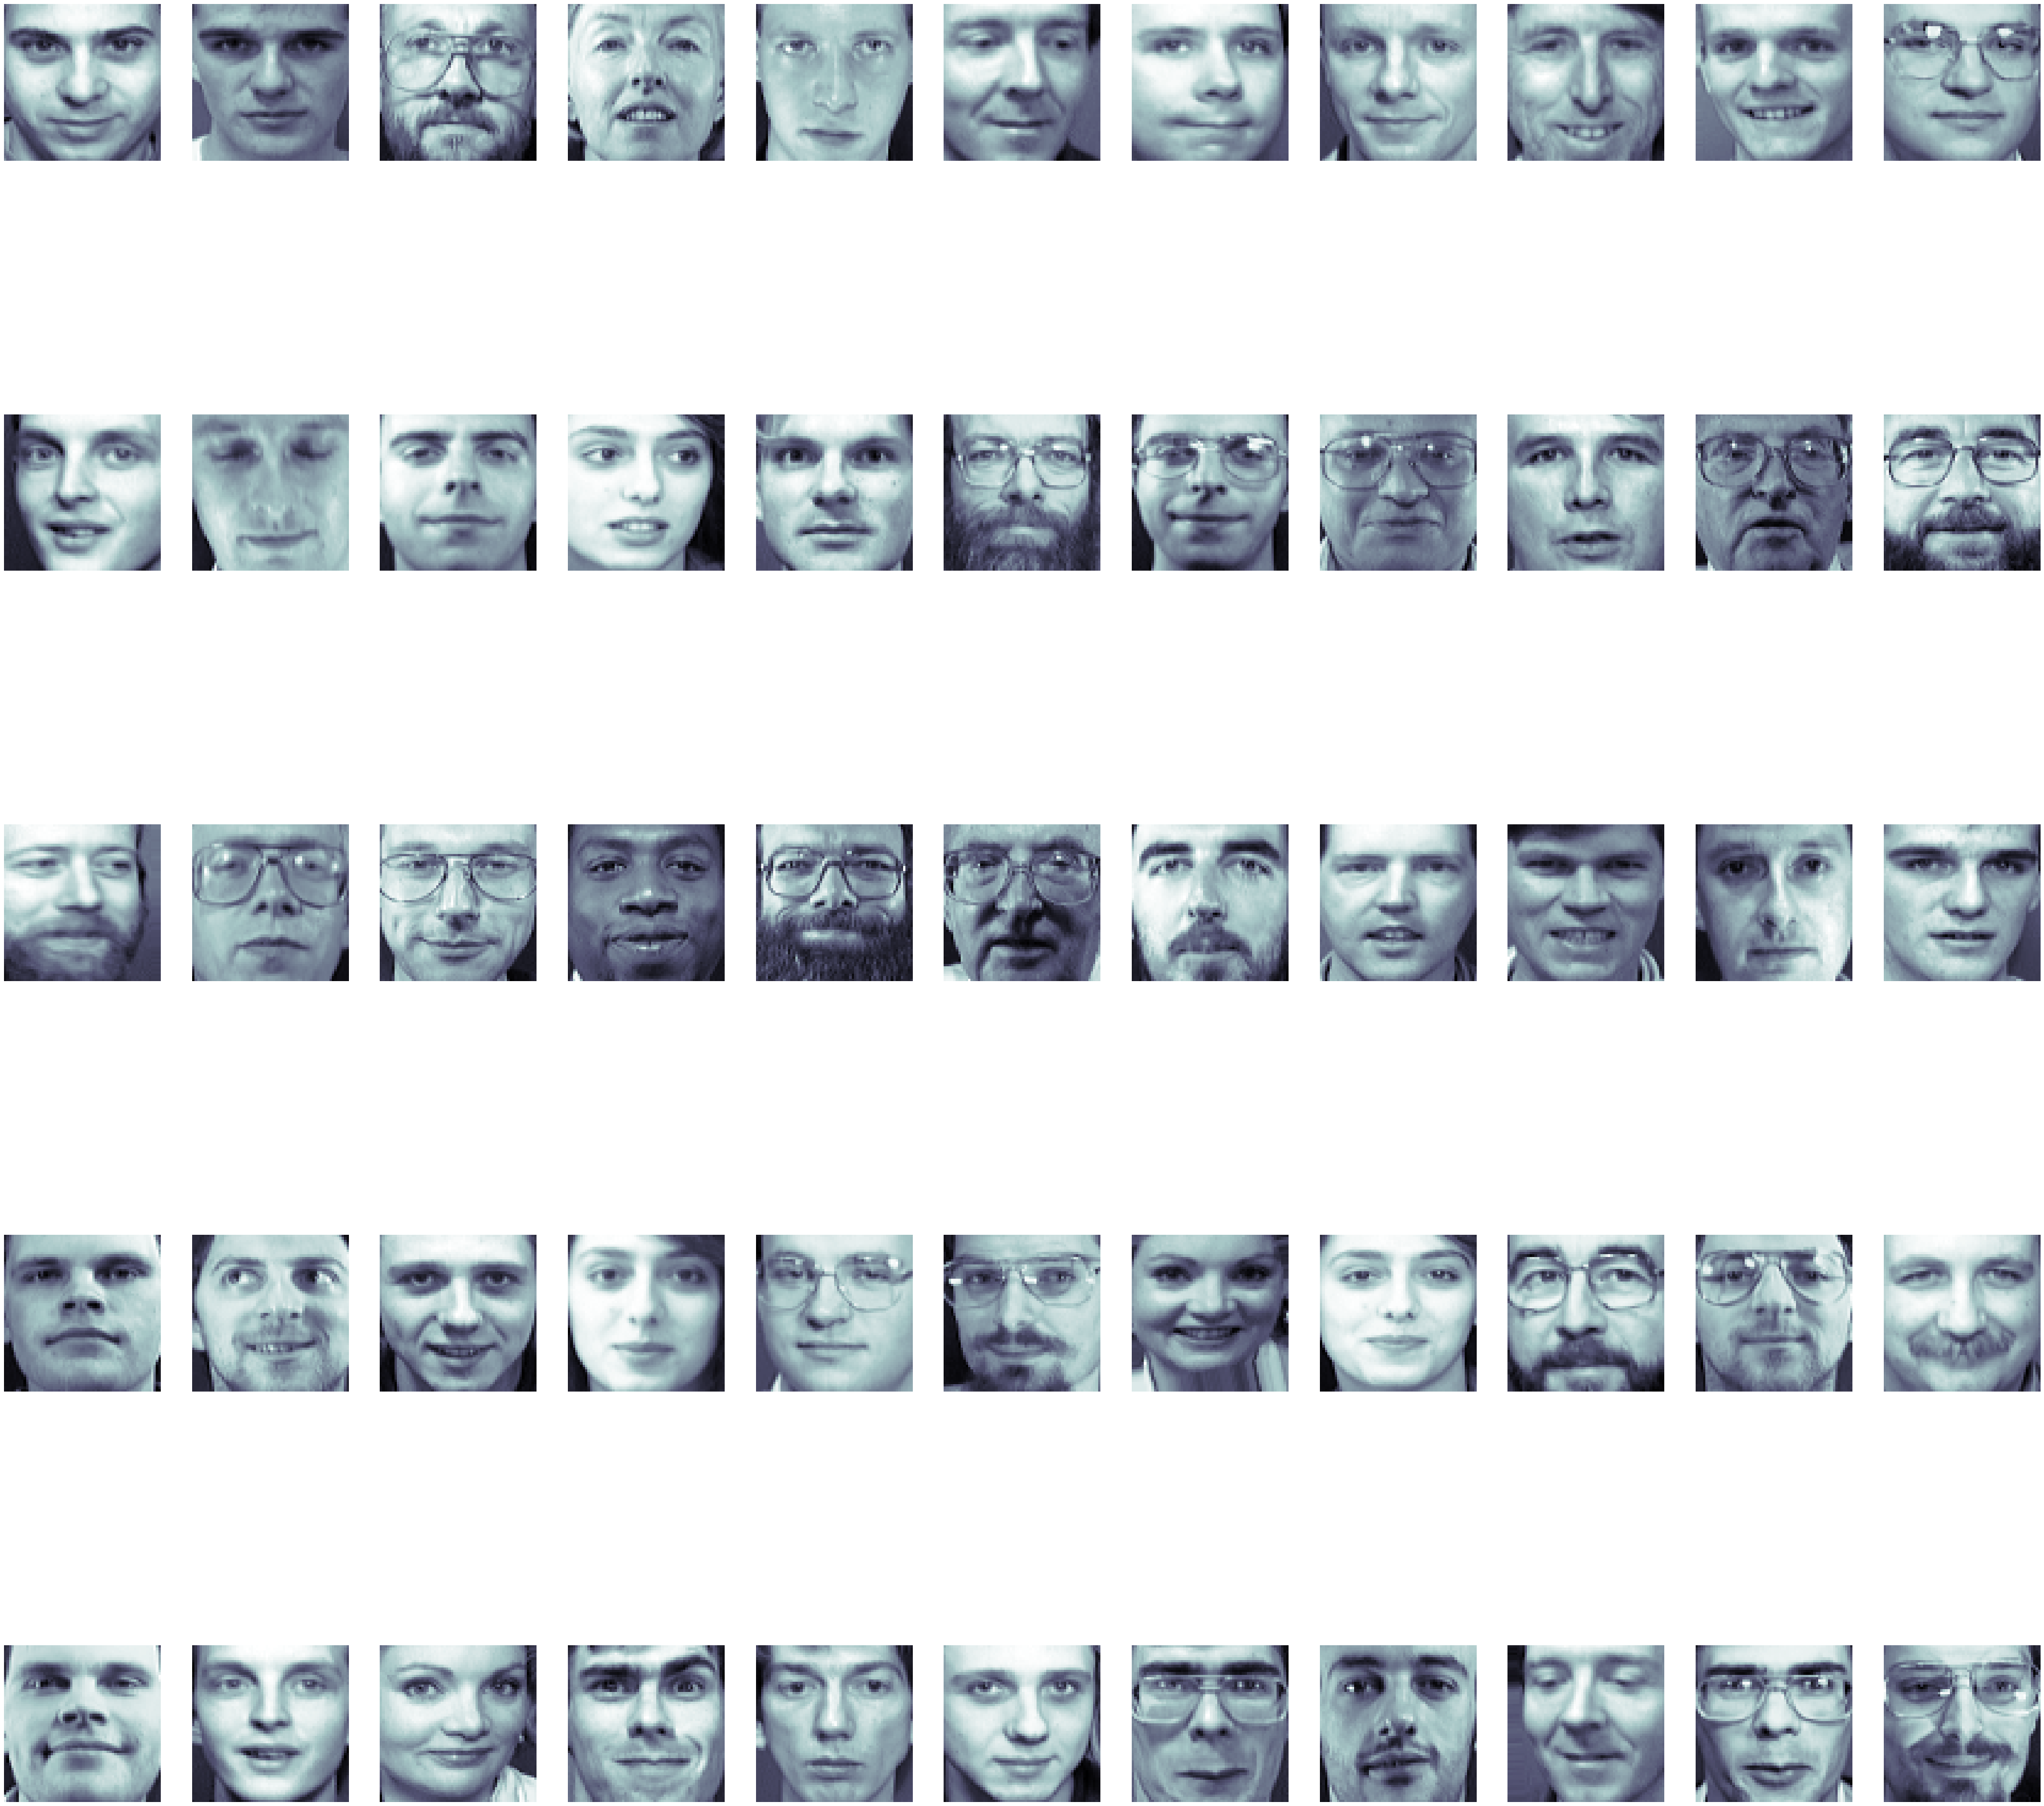

In [106]:
plt.figure(figsize=(64,64))
for i,j in enumerate(X_faces):
    plt.subplot(K//10,11,i+1)
    plt.imshow(j.reshape(64,64),cmap=plt.cm.bone)
    plt.axis("off")

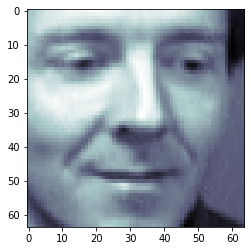

In [108]:
plt.imshow(X_train[np.argmin(X_transformed,axis=0)][5].reshape(64,64),cmap=plt.cm.bone) # closest to the centroid

In [110]:
# y_faces from the representatinve index
y_faces=y_train[representative_idx]
y_faces.reshape(5,-1)

array([[ 8, 29, 13, 31,  0,  2, 22, 20, 38,  4,  5],
       [39, 23, 18,  7, 17, 36, 18, 30, 14, 33, 27],
       [25,  1, 26, 21, 36, 33, 10, 37, 32, 23, 29],
       [35,  6, 11,  7,  5, 16, 34,  7, 27,  6, 24],
       [35, 39, 34, 19, 28, 11, 19, 15,  2, 19, 16]])

In [111]:
log_reg=LogisticRegression(random_state=42,multi_class="ovr",max_iter=2000)
log_reg.fit(X_faces,y_faces)

LogisticRegression(max_iter=2000, multi_class='ovr', random_state=42)

In [112]:
print(log_reg.score(X_test,y_test))
print(log_reg.score(X_faces,y_faces))
print(log_reg.score(X_train,y_train))

0.7
1.0
0.7875


In [113]:
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54], dtype=int32)

In [114]:
labels[:100]

array([13, 21, 13, 31, 21, 31, 13,  5, 13, 21, 16, 16, 16, 16, 37, 16, 16,
       16, 16, 16,  2, 29, 29, 14,  9, 14,  5,  5,  1,  1,  4,  4,  4, 20,
       20,  5, 20,  4,  4, 37, 22, 29,  2, 22, 22, 22, 22, 22, 22,  5, 20,
       20, 20, 23, 23, 23, 23, 23, 23, 23, 19, 19,  5, 19, 19,  5, 19, 19,
        5, 19,  8,  8,  8, 21,  8,  8, 21,  8,  5, 21,  2,  2,  2, 22, 22,
       22, 22, 22, 22,  4,  4,  1,  2,  2,  1,  1,  1,  1,  5,  8],
      dtype=int32)

### give the label to all the instance that are in the same cluster

- label propagation

In [115]:
y_train_propagated_label=np.empty(len(X_train))
print(y_train_propagated_label.shape)
for i in range(K):
    y_train_propagated_label[kmeans.labels_==i]=y_faces[i]

(320,)


In [116]:
np.unique(y_train_propagated_label,return_counts=True)

(array([ 0.,  1.,  2.,  4.,  5.,  6.,  7.,  8., 10., 11., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.]),
 array([ 3, 10, 10,  7,  9,  7, 10, 12,  8,  9,  8, 18,  2,  6, 13,  9,  8,
         7,  8, 11,  8,  7, 10,  8,  7,  4, 18,  4,  7,  8,  8,  5,  6,  8,
         6, 12, 19]))

In [117]:
np.unique(y_train,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]))

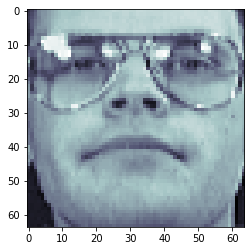

In [118]:
plt.imshow(X_train[300].reshape(64,64),cmap=plt.cm.bone)

In [119]:
y_train[300], y_train_propagated_label[300]

(35, 35.0)

### model training with the new propagated data

In [120]:
log_reg=LogisticRegression(multi_class="ovr",max_iter=2000,random_state=42)
log_reg.fit(X_train,y_train_propagated_label)
print(log_reg.score(X_test,y_test))

0.7


### propagation accuracy

In [122]:
homogeneity_completeness_v_measure(y_train,y_train_propagated_label)

(0.8139881821304072, 0.8521647550145649, 0.8326390985433948)

In [123]:
np.mean(y_train==y_train_propagated_label)

0.734375

In [124]:
accuracy_score(y_train,y_train_propagated_label)

0.734375

**Propagation accuracy is 73%. We can try to improve it by propagating the labels only to a threshold near to the centroid.**

 ## Increase the accuracy by propagating only to the instances that are really close to the centroid
 
 
if we propagate the instances to the full cluster it might have an outlier so the most commonly used technique is to propagate the label to some threshold closest to the centroid.
The commonly used threshold is a precentile according to the data.

In [125]:
print(f"cluster centroid shape : {kmeans.cluster_centers_.shape}")
print(f"cluster centroid label : {kmeans.labels_[0]}")

cluster centroid shape : (55, 4096)
cluster centroid label : 54


In [126]:
X_transformed[0]

array([ 8.823442 , 11.964177 , 10.736468 , 11.313115 ,  8.835166 ,
       11.943437 , 10.038459 , 10.868067 , 14.586465 ,  9.039463 ,
       11.243362 ,  9.206025 , 11.370971 , 11.087468 , 15.622952 ,
        9.09951  , 12.738904 , 10.93094  , 14.223973 , 10.059459 ,
       15.966128 , 11.822388 , 10.70807  , 11.490821 , 10.510619 ,
       15.654417 , 14.895726 , 18.310844 , 12.067606 , 10.626494 ,
       14.214261 , 13.040922 , 10.846858 , 10.556491 , 12.771449 ,
       11.310593 , 13.988276 , 12.062604 , 10.3211775, 14.275435 ,
       11.288625 , 10.710005 ,  9.2603445, 10.556492 , 13.372834 ,
        8.97129  , 12.233021 , 11.511491 , 11.191044 ,  9.081974 ,
       13.233981 , 12.577288 , 12.104106 , 11.065995 ,  5.006219 ],
      dtype=float32)

In [127]:
X_transformed[0][np.argmin(X_transformed[0])]

5.006219

In [128]:
percentile=80 # took 80% of the instances that are closest to the centroid
X_cluster_distance=X_transformed[np.arange(len(X_train)),kmeans.labels_]
for i in range(K):
    intra_cluster=kmeans.labels_==i
    cluster_dist=X_cluster_distance[intra_cluster]
    dist=np.percentile(cluster_dist,percentile)
    upper_dis=(X_cluster_distance>dist)
    X_cluster_distance[intra_cluster&upper_dis]=-1

In [129]:
X_cluster_distance[:20]

array([-1.       ,  3.4298959, -1.       ,  3.4330797, -1.       ,
       -1.       ,  4.1278586,  3.3963695, -1.       ,  4.361188 ,
        5.107123 ,  3.3165965, -1.       , -1.       ,  4.54122  ,
        4.5495396,  4.42551  ,  3.931181 , -1.       ,  3.7909224],
      dtype=float32)

In [130]:
X_cluster_distance.shape

(320,)

In [131]:
np.sum(X_cluster_distance!=-1)

244

In [132]:
propagation_cutoff=(X_cluster_distance!=-1)
X_train_partially_select=X_train[propagation_cutoff]
y_train_partially_select=y_train_propagated_label[propagation_cutoff]

In [133]:
log_reg=LogisticRegression(multi_class="ovr",max_iter=2000,random_state=42)
log_reg.fit(X_train_partially_select,y_train_partially_select)
print(log_reg.score(X_test,y_test))

0.6625


In [134]:
np.mean(y_train_partially_select==y_train[propagation_cutoff])

0.7950819672131147

**Accuracy increased from 73% to 80% by propagating only to the instances that are really close to the centroid**